In [94]:
import eli5
from eli5.sklearn import PermutationImportance
import pandas as pd
import xarray as xr
import glob
import os
import netCDF4
import scipy
from scipy import stats
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import pickle
import warnings

import random

#import neighbour_functions
from haversine_distance import haversine_distance
#from make_data_features import make_data_features
# from neighbour_functions import compute_neighbours_stats
# from neighbour_functions import add_nearby_observations
# from neighbour_functions import additional_stats

import cartopy as cart
from cartopy.mpl.ticker import LongitudeFormatter, LatitudeFormatter
import cartopy.crs as ccrs

from datetime import datetime

from matplotlib.patches import Rectangle

In [95]:
def compute_neighbours_stats(selection,distance,time_stamp,criterion) :

    r = 2
    
    if criterion == 'distance':
    
        #Find points no further than 250 km
        selection_neighbour_one = selection.loc[( (selection['distance'] < distance) & (selection['distance'] >=1)) ]
        #selection_neighbour_one = selection.loc[ (selection['distance'] < distance)  ]

        # Put selection in ascending order based on distance
        selection_neighbour_one = selection_neighbour_one.sort_values(['distance'])
        
    elif criterion == 'time':
        
        #Find points no further than some days
        time_diff_selection = abs(selection.date-pd.to_datetime(time_stamp)).dt.total_seconds()+1 #(one second is added to avoid infinite values for observations taken in the same hour)
        selection_neighbour_one = selection.loc[( (time_diff_selection < distance) & (selection['distance'] >=1) & (selection['distance'] <=300) ) ]
        # Put selection in ascending order based on distance
        selection_neighbour_one = selection_neighbour_one.sort_values(['distance'])    

    # Space weighting coefficient
    lambda_coeff_one = selection_neighbour_one.distance**(-r)  / np.sum(selection_neighbour_one.distance**(-r))
    #lambda_coeff_one = 1./( (selection_neighbour_one.distance*0.01)**(r) ) 
    

    # Time weighting coefficient    
    time_diff = (abs(selection_neighbour_one.date-pd.to_datetime(time_stamp)).dt.total_seconds()+1)*10**(-4) 
    #(one second is added to avoid infinite values for observations taken in the same hour)
    #Time difference (in seconds) is multiplied by the power of -4 in order to have similar numbers to space distances (in Km)
    lambda_coeff_two = time_diff**(-r)  / np.sum(time_diff**(-r))


    sla_weighted_space = np.sum   (lambda_coeff_one *  selection_neighbour_one.sla )
    #sla_weighted_space = sum   (lambda_coeff_one *  selection_neighbour_one.sla ) / sum   (lambda_coeff_one)
    
    sla_weighted_time = np.sum   (lambda_coeff_two *  selection_neighbour_one.sla )
    sla_spread = np.nanstd(selection_neighbour_one.sla)
    sla_average = np.nanmean(selection_neighbour_one.sla)       
    
    return selection_neighbour_one, sla_weighted_space, sla_weighted_time, sla_spread, sla_average

def add_nearby_observations(X_new,X,y):
    
    #X_new is the dataframe that needs to add the closest values as attributes
    #X is the dataframe in which to find the closest values
    #y is the dataframe containing the truth
    
    
    # NEIGHBOUR ONE
    
    z_k1 = np.empty(np.shape(X_new)[0])  #sla average
    z_tilde_k1 = np.empty(np.shape(X_new)[0]) #sla weighted average in space
    z_tildetime_k1 = np.empty(np.shape(X_new)[0]) #sla weighted average in space
    sigma_k1 = np.empty(np.shape(X_new)[0])  #sla spread
    
    z_u1 = np.empty(np.shape(X_new)[0])  #sla average
    z_tilde_u1 = np.empty(np.shape(X_new)[0]) #sla weighted average in space
    z_tildetime_u1 = np.empty(np.shape(X_new)[0]) #sla weighted average in space
    sigma_u1 = np.empty(np.shape(X_new)[0])  #sla spread    
    
    
    # NEIGHBOUR TWO
    
    z_k2 = np.empty(np.shape(X_new)[0])  #sla average
    z_tilde_k2 = np.empty(np.shape(X_new)[0]) #sla weighted average in space
    z_tildetime_k2 = np.empty(np.shape(X_new)[0]) #sla weighted average in space
    sigma_k2 = np.empty(np.shape(X_new)[0])  #sla spread   
    
    z_u2 = np.empty(np.shape(X_new)[0])  #sla average
    z_tilde_u2 = np.empty(np.shape(X_new)[0]) #sla weighted average in space
    z_tildetime_u2 = np.empty(np.shape(X_new)[0]) #sla weighted average in space
    sigma_u2 = np.empty(np.shape(X_new)[0])  #sla spread       
    
    # NEIGHBOUR Three
    
    z_k3 = np.empty(np.shape(X_new)[0])  #sla average
    z_tilde_k3 = np.empty(np.shape(X_new)[0]) #sla weighted average in space
    z_tildetime_k3 = np.empty(np.shape(X_new)[0]) #sla weighted average in space
    sigma_k3 = np.empty(np.shape(X_new)[0])  #sla spread  
    
    z_u3 = np.empty(np.shape(X_new)[0])  #sla average
    z_tilde_u3 = np.empty(np.shape(X_new)[0]) #sla weighted average in space
    z_tildetime_u3 = np.empty(np.shape(X_new)[0]) #sla weighted average in space
    sigma_u3 = np.empty(np.shape(X_new)[0])  #sla spread      
    
    
    #Add datetime object to X
    temp = X.drop(columns=['elevation','lon','lat'])
    temp = pd.to_datetime(temp)
    X['date'] = temp
    

    #use the random choice to vary the grid point to display as example, otherwise fix it for the paper
    index = random.choice (np.arange(0,np.shape(X_new)[0])) 
    index = 500
    
    #datetime of current point 
    time_stamp = datetime(int(X_new.iloc[index].year),int(X_new.iloc[index].month),int(X_new.iloc[index].day),int(X_new.iloc[index].hour))


    #Find points within a certain time and space bound, but not from the same track at the same cycle 
    selection = X.loc[ (abs((X['date'] - time_stamp ).dt.days)< 30) & \
                      ( abs((X['date'] - time_stamp ).dt.seconds)> 3600 ) & \
                     (abs((X['lat'] - X_new.iloc[index].lat))< 2.5) ]  

    #Add distance from point
    selection['distance'] = haversine_distance(X_new.iloc[index].lat, X_new.iloc[index].lon, selection.lat, selection.lon)

    #Add SLA of selected points
    selection['sla'] = y[y.index.isin(selection.index)]


    # LETTER k IDENTIFIES THE NEIGHBOUROODS IN SPACE

    selection_neighbour_one_100, z_tilde_k1[index], z_tildetime_k1[index], sigma_k1[index], z_k1[index] = \
                compute_neighbours_stats(selection,100,time_stamp,'distance')

    selection_neighbour_one_200, z_tilde_k2[index], z_tildetime_k2[index], sigma_k2[index], z_k2[index] = \
                compute_neighbours_stats(selection,200,time_stamp,'distance')

    selection_neighbour_one_300, z_tilde_k3[index], z_tildetime_k3[index], sigma_k3[index], z_k3[index] = \
                compute_neighbours_stats(selection,300,time_stamp,'distance')

    # LETTER u IDENTIFIES THE NEIGHBOUROODS IN TIME

    selection_neighbour_one_5, z_tilde_u1[index], z_tildetime_u1[index], sigma_u1[index], z_u1[index] = \
                compute_neighbours_stats(selection,5*86400,time_stamp,'time')

    selection_neighbour_one_15, z_tilde_u2[index], z_tildetime_u2[index], sigma_u2[index], z_u2[index] = \
                compute_neighbours_stats(selection,15*86400,time_stamp,'time')

    selection_neighbour_one_30, z_tilde_u3[index], z_tildetime_u3[index], sigma_u3[index], z_u3[index] = \
                compute_neighbours_stats(selection,30*86400,time_stamp,'time')        
    
    X = X.drop(columns=['date'])

    # Addition of statistics relative to a single neighbour

    X_new['z_k1'] = z_k1
    X_new['z_tilde_k1'] = z_tilde_k1
    X_new['z_tildetime_k1'] = z_tildetime_k1
    X_new['sigma_k1'] = sigma_k1     
    
    X_new['z_k2'] = z_k2
    X_new['z_tilde_k2'] = z_tilde_k2
    X_new['z_tildetime_k2'] = z_tildetime_k2
    X_new['sigma_k2'] = sigma_k2 
    
    X_new['z_k3'] = z_k3
    X_new['z_tilde_k3'] = z_tilde_k3
    X_new['z_tildetime_k3'] = z_tildetime_k3
    X_new['sigma_k3'] = sigma_k3 
    
    X_new['z_u1'] = z_u1
    X_new['z_tilde_u1'] = z_tilde_u1
    X_new['z_tildetime_u1'] = z_tildetime_u1
    X_new['sigma_u1'] = sigma_u1     
    
    X_new['z_u2'] = z_u2
    X_new['z_tilde_u2'] = z_tilde_u2
    X_new['z_tildetime_u2'] = z_tildetime_u2
    X_new['sigma_u2'] = sigma_u2 
    
    X_new['z_u3'] = z_u3
    X_new['z_tilde_u3'] = z_tilde_u3
    X_new['z_tildetime_u3'] = z_tildetime_u3
    X_new['sigma_u3'] = sigma_u3 
    

    return selection_neighbour_one_100, selection_neighbour_one_200, selection_neighbour_one_300, \
selection_neighbour_one_5, selection_neighbour_one_15, selection_neighbour_one_30, X_new


In [96]:
#Choose region #BALTIC or #NORTHSEA
region = 'NORTHSEA'

#Choose Data Location
location = 'cmems'

#Choose year to consider
year_of_choice = 2004

# Choose how larger the dataset should be w.r.t. the prediction zone (in degrees of latitude and longitude)
enlarge_dataset = 2.5

if region in {'BALTIC'} :
    max_lat = 66.0
    min_lat = 53.0
    max_lon = 31.0
    min_lon = 9.0
    
    max_lat_large = 66.0 + enlarge_dataset
    min_lat_large = 53.0 - enlarge_dataset
    max_lon_large = 31.0 + enlarge_dataset
    min_lon_large = 9.0  - enlarge_dataset    
     
    
    #Name of the dataset containing altimetry observations
    altimetry_dataset = "/DGFI8/H/work_marcello/machine_learning_altimetry/ds_full_newtraining.pkl"

elif region in {'NORTHSEA'} :
    
    max_lat = 61.0
    min_lat = 50.0
    max_lon = 12.2
    min_lon = -4.0
    
    max_lat_large = 61.0 + enlarge_dataset
    min_lat_large = 50.0 - enlarge_dataset
    max_lon_large = 12.2 + enlarge_dataset
    min_lon_large = -4.0  - enlarge_dataset      
    
    
    #Name of the dataset containing altimetry observations
    altimetry_dataset = "/DGFI8/H/work_marcello/machine_learning_altimetry/ds_full_newtraining_NORTHSEA.pkl"    
    
    

In [97]:
# Load dataframe containing altimetry observations

if location in {'cmems'} :
    ds_full = pd.read_pickle(altimetry_dataset)
    #CASE CMEMS
    ds_full = ds_full.rename(columns = {'longitude': 'lon', 'latitude': 'lat', 'sla_unfiltered': 'sla'}, inplace = False)

elif location in {'balticplus'} :
    ds_full = pd.read_pickle(altimetry_dataset)
    #CASE Baltic plus
    ds_full = ds_full.rename(columns = {'sla_unfiltered': 'sla'}, inplace = False)



Transform the xarray dataset into pandas dataframe. A possibility to convert longitude and latitude coordinates into trigonometric functions is given

In [98]:
def convert_coordinates(ds_full):

    ds_full['A'] = np.sin(np.radians(ds_full.lat.values)) 
    ds_full['B'] = np.sin(np.radians(ds_full.lon.values)) * np.cos(np.radians(ds_full.lat.values))
    ds_full['C'] = -np.cos(np.radians(ds_full.lon.values)) * np.cos(np.radians(ds_full.lat.values))
    
    return ds_full

def make_data_features(ds,field_names):

    """Export selected fields of an xarray dataset into a new pandas dataframe
    
    Parameters
    ----------
    ds: an xarray dataset
    field_names: fields of ds that we want to transfer to the dataframe
    
    Returns
    -------
    data_features: xarray dataset containing field_names as fields
    X: data_features transformed into a pandas dataframe
    """     
    counter = 0
    for field in field_names :
        
        if counter == 0 :
            
            data_features = {field : ds[field]}
            counter = counter + 1
            
        else:
            
            if field in {'year'} :
                
                data_features[field] = ds.time_model.dt.year
            
            elif field in {'month'} :
                
                data_features[field] = ds.time_model.dt.month
                
            elif field in {'day'} :
                
                data_features[field] = ds.time_model.dt.day

            elif field in {'hour'} :
                
                data_features[field] = ds.time_model.dt.hour                 
                
            else :
                
                data_features[field] = ds[field]
                
    
    X = pd.DataFrame(data=data_features)
    X.columns = field_names 

    return data_features, X


#Activate this to convert latitude and longitude
#ds_full = convert_coordinates(ds_full)




field_names = [  'elevation','lon','lat','year','month','day','hour']


data_features, X = make_data_features(ds_full,field_names)


data_target = {'sla': ds_full.sla}
y = pd.DataFrame(data=data_target)
y.columns =['sla'] 


Possibilities to reduce size of training dataset + save a copy of the original altimetry dataset to be used for training (X and y), before any modification

In [99]:
# Selection of specific years
X = X.loc[ (X['year'] == year_of_choice)  ]
y = y[y.index.isin(X.index)]

# Save X as it is now, i.e. with larger areas compared to the training and prediction points
X_original = X.copy()
y_original = y.copy()

# # Downsampling
# X = X.iloc[::20]
# y = y.iloc[::20]



Regional exclusions (restrict area to training and prediction points

In [100]:
if region in {'BALTIC'} :
    # Eliminate Skagerrak and Kattegat
    X = X.loc[ ~( (X.lon < 13.0) & (X.lon > 9) &   \
                              (X.lat < 60.0) & (X.lat > 55.0) )]

    # Eliminate North-West Norway angle
    X = X.loc[ ~( (X.lon < 12.3)  )]
    
X = X.loc[ ( (X.lon < max_lon) & (X.lon > min_lon) &   \
                              (X.lat < max_lat) & (X.lat > min_lat) )]

In [101]:
# Remove warnings
from importlib import reload
pd.options.mode.chained_assignment = None  # default='warn'
import warnings
warnings.filterwarnings('ignore')


Add neighbouring observations to Training Dataset

In [102]:
# Choose one day of grid
groups = X.groupby(['year','month','day'])


counter = 0

for group_key, group_value in groups:
    group = groups.get_group(group_key)
    y_group = y.loc[group.index]

    print(group_key)



    # Create neighboroods
    try:
        X_original=X_original.drop(columns=['date'])
        group=group.drop(columns=['date'])
        X=X.drop(columns=['date'])            
    except:
        print()

    selection_neighbour_one_100, selection_neighbour_one_200, selection_neighbour_one_300, \
selection_neighbour_one_5, selection_neighbour_one_15, selection_neighbour_one_30,group = add_nearby_observations(group,X_original,y_original)

    break


(2004, 1, 1)



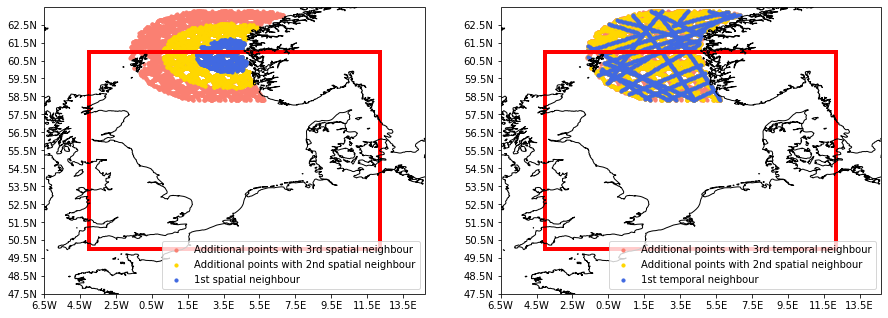

In [103]:
fig = plt.figure(figsize = (15, 10))

counter = 1
ax=fig.add_subplot(1,2,counter,projection=ccrs.PlateCarree())

ax.set_xticks(np.arange(min_lon_large,max_lon_large,2), crs=ccrs.PlateCarree())
ax.set_yticks(np.arange(min_lat_large,max_lat_large,1), crs=ccrs.PlateCarree())    

#ax = plt.axes(projection=ccrs.Miller()) 
img_three=plt.scatter(selection_neighbour_one_300.lon, selection_neighbour_one_300.lat,label="Additional points with 3rd spatial neighbour", s=10, alpha=1,color='salmon')
img_two=plt.scatter(selection_neighbour_one_200.lon, selection_neighbour_one_200.lat,label="Additional points with 2nd spatial neighbour", s=10, alpha=1,color='gold')
img=plt.scatter(selection_neighbour_one_100.lon, selection_neighbour_one_100.lat,label="1st spatial neighbour", s=10, alpha=1,color='royalblue')
ax.coastlines(resolution='10m', color='black', linewidth=1) 
plt.xlim(min_lon_large,max_lon_large)
plt.ylim(min_lat_large,max_lat_large)
plt.legend(frameon=True,loc='lower right',facecolor='white')

lon_formatter = cart.mpl.ticker.LongitudeFormatter(number_format='.1f', 
                                  degree_symbol='', 
                                  dateline_direction_label=True)
lat_formatter = cart.mpl.ticker.LatitudeFormatter(number_format='.1f', 
                                 degree_symbol='')
ax.xaxis.set_major_formatter(lon_formatter)
ax.yaxis.set_major_formatter(lat_formatter) 

plt.gca().add_patch(Rectangle((min_lon,min_lat),abs(max_lon-min_lon),abs(max_lat-min_lat),
                    edgecolor='red',
                    facecolor='none',
                    lw=4))

#-----------

counter = counter+1

ax=fig.add_subplot(1,2,counter,projection=ccrs.PlateCarree())

ax.set_xticks(np.arange(min_lon_large,max_lon_large,2), crs=ccrs.PlateCarree())
ax.set_yticks(np.arange(min_lat_large,max_lat_large,1), crs=ccrs.PlateCarree())    

#ax = plt.axes(projection=ccrs.Miller()) 
img_three=plt.scatter(selection_neighbour_one_30.lon, selection_neighbour_one_30.lat,label="Additional points with 3rd temporal neighbour",s=10, alpha=1,color='salmon')
img_two=plt.scatter(selection_neighbour_one_15.lon, selection_neighbour_one_15.lat,label="Additional points with 2nd spatial neighbour", s=10, alpha=1,color='gold')
img=plt.scatter(selection_neighbour_one_5.lon, selection_neighbour_one_5.lat,label="1st temporal neighbour", s=10, alpha=1,color='royalblue')
ax.coastlines(resolution='10m', color='black', linewidth=1) 
plt.xlim(min_lon_large,max_lon_large)
plt.ylim(min_lat_large,max_lat_large)

plt.legend(frameon=True,loc='lower right',facecolor='white')

lon_formatter = cart.mpl.ticker.LongitudeFormatter(number_format='.1f', 
                                  degree_symbol='', 
                                  dateline_direction_label=True)
lat_formatter = cart.mpl.ticker.LatitudeFormatter(number_format='.1f', 
                                 degree_symbol='')
ax.xaxis.set_major_formatter(lon_formatter)
ax.yaxis.set_major_formatter(lat_formatter) 


plt.gca().add_patch(Rectangle((min_lon,min_lat),abs(max_lon-min_lon),abs(max_lat-min_lat),
                    edgecolor='red',
                    facecolor='none',
                    lw=4))

fig.savefig("fig_neighbourexample.png")
